# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

In [33]:
from fastai import *
from fastai.vision import *

In [34]:
import warnings
warnings.filterwarnings('ignore')

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels

In [2]:
import pixiedust

Pixiedust database opened successfully


In [35]:
folder = 'skiffs'
file = 'urls-skiffs.txt'

In [36]:
path = Path('/root/.fastai/data/boats')

In [37]:
path.ls()

[PosixPath('/root/.fastai/data/boats/urls-kayaks.txt'),
 PosixPath('/root/.fastai/data/boats/urls-skiffs.txt'),
 PosixPath('/root/.fastai/data/boats/urls-canoes.txt'),
 PosixPath('/root/.fastai/data/boats/canoes'),
 PosixPath('/root/.fastai/data/boats/kayaks'),
 PosixPath('/root/.fastai/data/boats/skiffs'),
 PosixPath('/root/.fastai/data/boats/models')]

In [38]:
dest = path/folder

In [39]:
dest.mkdir(parents=True, exist_ok=True)

In [40]:
path.ls()

[PosixPath('/root/.fastai/data/boats/urls-kayaks.txt'),
 PosixPath('/root/.fastai/data/boats/urls-skiffs.txt'),
 PosixPath('/root/.fastai/data/boats/urls-canoes.txt'),
 PosixPath('/root/.fastai/data/boats/canoes'),
 PosixPath('/root/.fastai/data/boats/kayaks'),
 PosixPath('/root/.fastai/data/boats/skiffs'),
 PosixPath('/root/.fastai/data/boats/models')]

In [41]:
classes=['canoes','kayaks','skiffs']

In [10]:
download_images(path/file, dest)

Error https://www.microskiff.com/attachments/ambush-micro-skiff-png.38598/ HTTPConnectionPool(host='127.0.0.1', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd4d381a160>: Failed to establish a new connection: [Errno 111] Connection refused',))
Error https://www.microskiff.com/attachments/boat-1-jpg.22607/ HTTPConnectionPool(host='127.0.0.1', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd4d380f550>: Failed to establish a new connection: [Errno 111] Connection refused',))
Error https://boats-from-usa.com/sites/default/files/boats/not-specified/9122/not-specified-j12-87782.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
Error https://media.midcurrent.com.s3.amazonaws.com/wp-content/uploads/2013/06/mc_adipose11.jpg HTTPSConnectionPool(host='media.midcurrent.com.s3.amazonaws.com', port=443

Then we can remove any images that can't be opened

In [42]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

canoes


kayaks


skiffs


## View data

In [43]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
             ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Lets take a look

In [44]:
data.classes

['canoes', 'kayaks', 'skiffs']

In [45]:
data.c

3

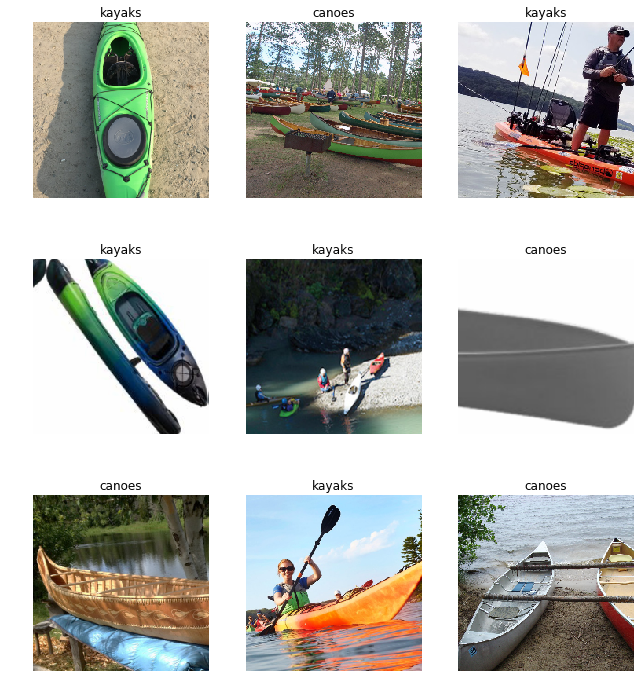

In [46]:
data.show_batch(rows=3)

In [47]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['canoes', 'kayaks', 'skiffs'], 3, 871, 217)

Some images are truncated with no data and this causes issue in training, by setting 
`ImageFile.LOAD_TRUNCATED_IMAGES=True` it fills in with a gray pixel and continues.

In [48]:
from PIL import ImageFile

In [49]:
ImageFile.LOAD_TRUNCATED_IMAGES=True

## Train Model

In [50]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [15]:

learn.fit_one_cycle(4)

Total time: 01:11
epoch  train_loss  valid_loss  error_rate
1      0.930074    0.320208    0.119816    (00:17)
2      0.653341    0.232623    0.087558    (00:17)
3      0.515452    0.230902    0.096774    (00:18)
4      0.423786    0.226701    0.082949    (00:17)



In [16]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


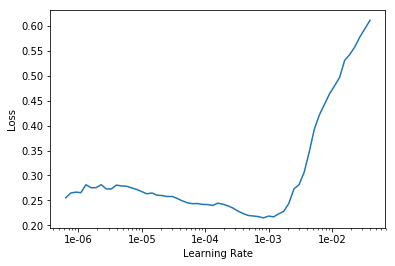

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2,max_lr=slice(3e-5,3e-4))

Total time: 00:37
epoch  train_loss  valid_loss  error_rate
1      0.265010    0.200596    0.082949    (00:17)
2      0.216681    0.189608    0.082949    (00:19)



In [22]:
learn.save('stage-2')

## Interpretation

In [51]:
learn.load('stage-2')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (871 items)
[Category canoes, Category canoes, Category canoes, Category canoes, Category canoes]...
Path: /root/.fastai/data/boats
x: ImageItemList (871 items)
[Image (3, 1944, 2592), Image (3, 1048, 1300), Image (3, 300, 640), Image (3, 469, 750), Image (3, 565, 848)]...
Path: /root/.fastai/data/boats;
Valid: LabelList
y: CategoryList (217 items)
[Category canoes, Category canoes, Category kayaks, Category kayaks, Category kayaks]...
Path: /root/.fastai/data/boats
x: ImageItemList (217 items)
[Image (3, 277, 855), Image (3, 345, 1000), Image (3, 1030, 1376), Image (3, 619, 1100), Image (3, 400, 696)]...
Path: /root/.fastai/data/boats;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, pa

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

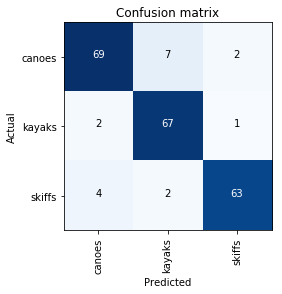

In [53]:
interp.plot_confusion_matrix()

## Cleanin Up

Some of top losses may be due to bad data labeling etc. There are images in our data set that shouldn't be there.

Using the `FileCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [54]:
from fastai.widgets import *

In [55]:
ds,idxs = DatasetFormatter.from_toplosses(learn, ds_type=DatasetType.Valid)

In [56]:
fd = ImageCleaner(ds, idxs)

'No images to show :)'

## Putting your model in production

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [57]:
import fastai

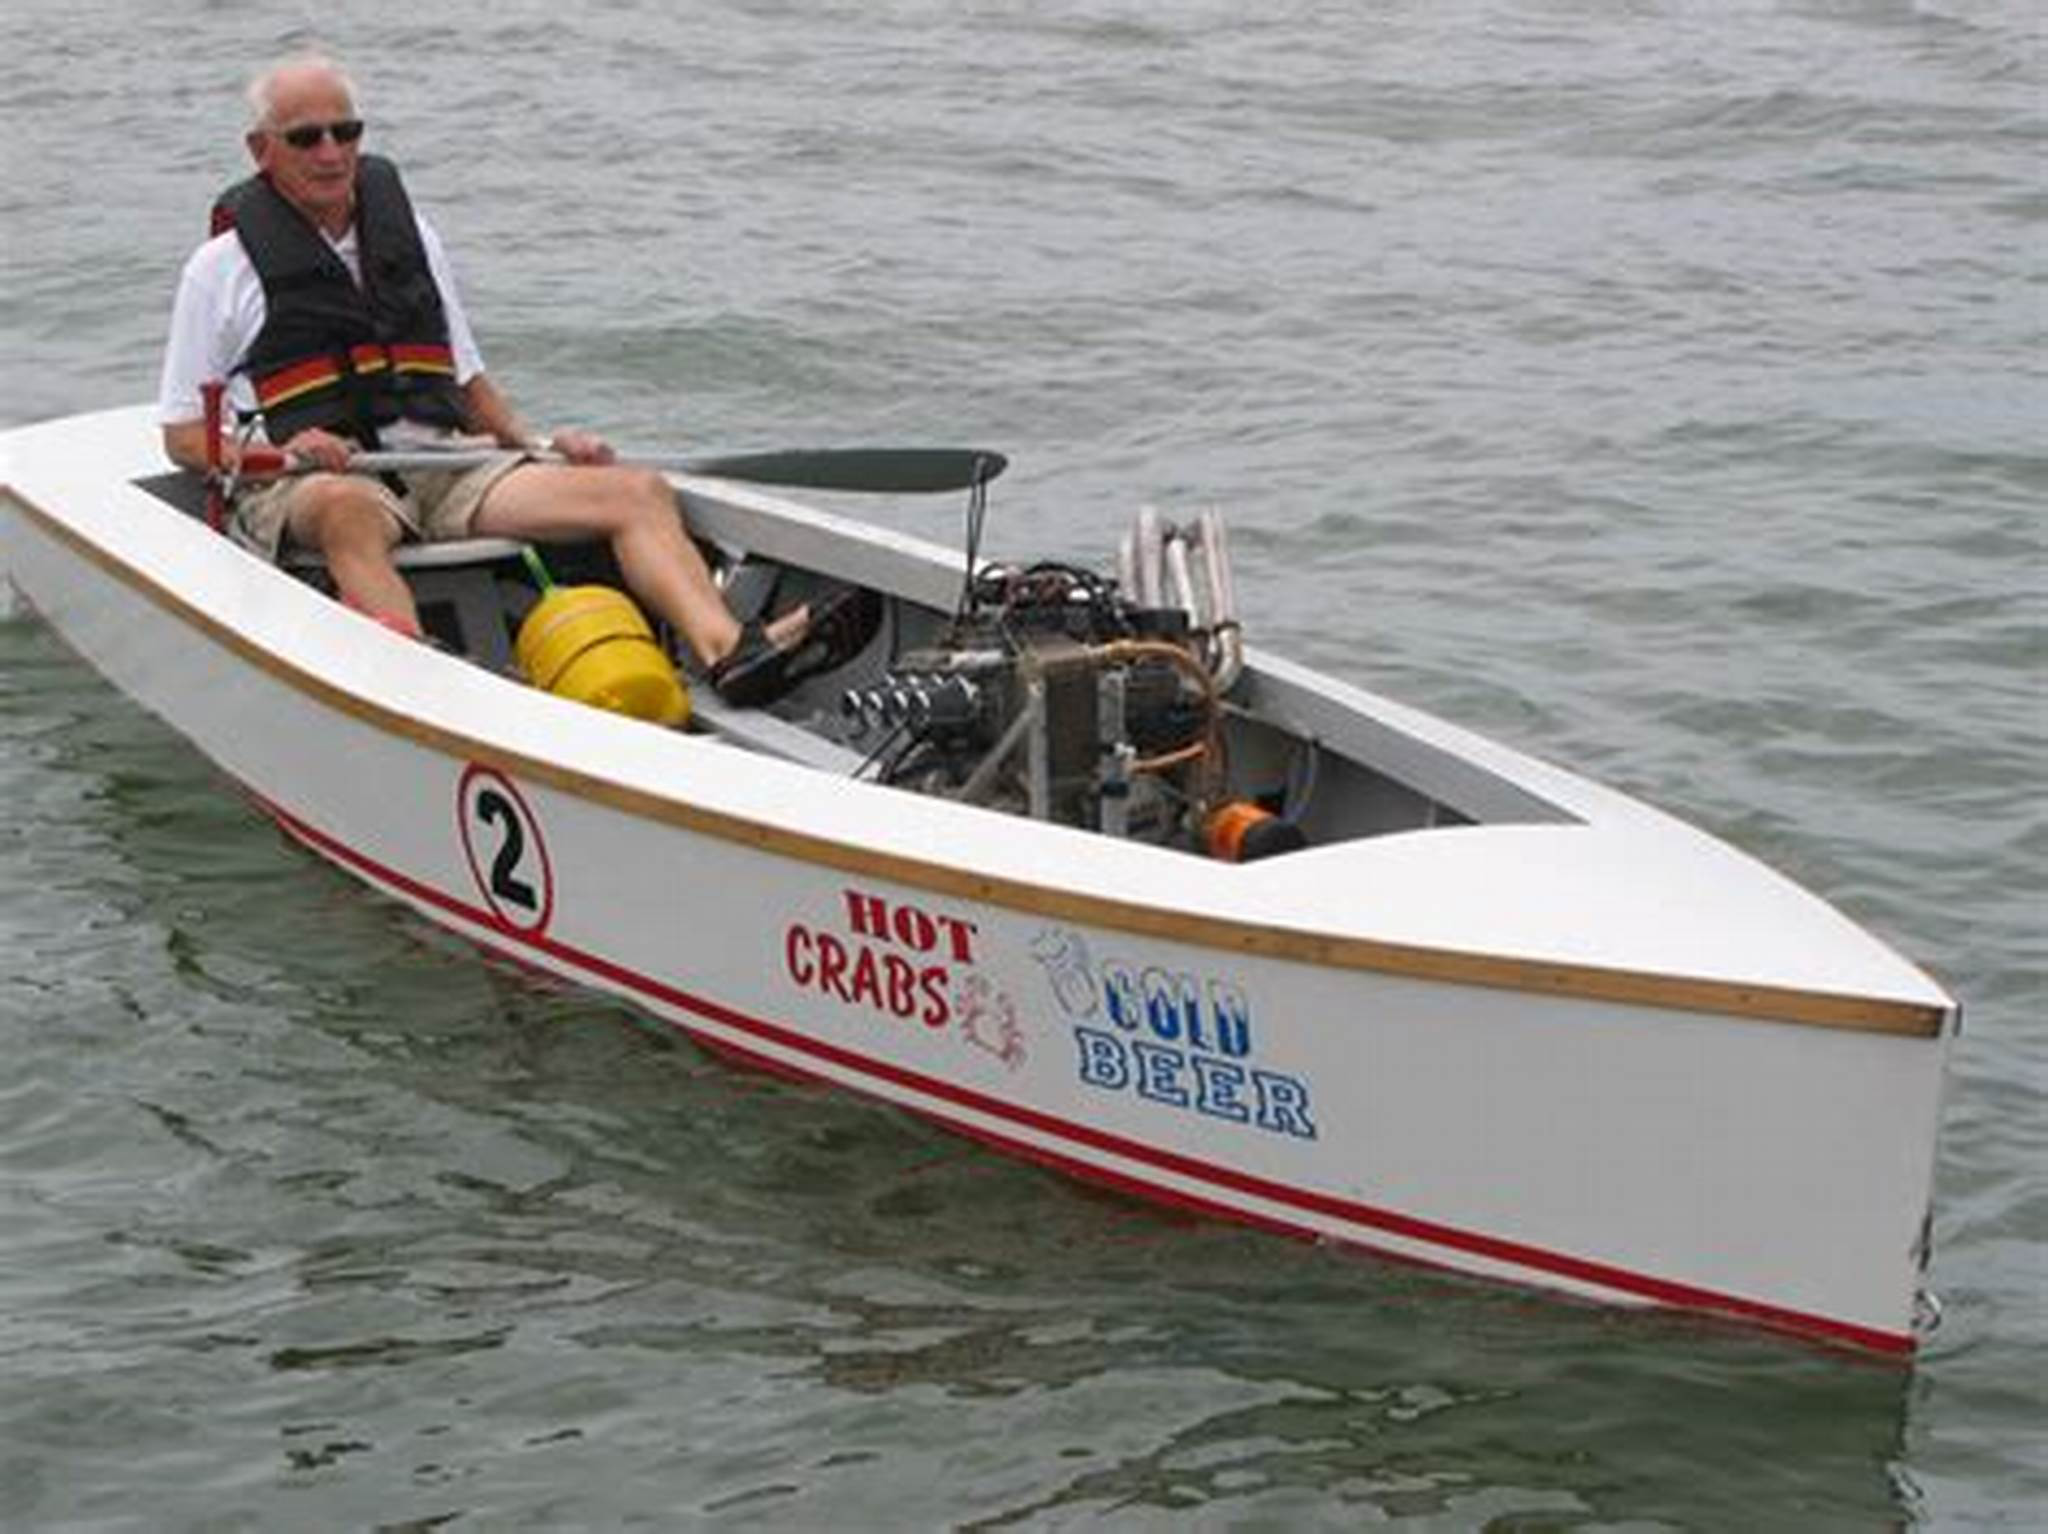

In [70]:
img = open_image('/root/.fastai/data/boats/skiff-test.jpeg')
img

In [59]:
classes

['canoes', 'kayaks', 'skiffs']

In [60]:
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [61]:
learn =  create_cnn(data2, models.resnet34).load('stage-2')

In [71]:
pred_class, pred_idx, outputs = learn.predict(img)

In [72]:
pred_class

'skiffs'